In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('dataframe1000rows.csv')
data.head()

,Nom,Ãge,NA,Cor,Cen,Drb,Apl,Agr,Fin,Ctn,...,Ant,TÃªt,Tir,T Lg,Mar,Pas,Pen,Tcl,Tec,NA_end
0,Matthijs de Ligt,23,160,4,7,10,9,16,8,13,...,14,16,10,5,16,14,8,16,13,168
1,Kim Min-Jae,26,162,2,7,11,8,17,7,14,...,15,16,6,7,16,14,6,16,12,163
2,Alphonso Davies,22,156,10,11,17,13,15,9,10,...,11,9,9,14,9,12,11,14,13,165
3,Dayot Upamecano,24,156,3,7,12,10,16,7,13,...,13,14,6,10,15,16,7,17,13,159
4,Niklas SÃ¼le,27,154,3,12,12,11,11,8,14,...,14,15,12,11,15,14,8,15,13,154


# Pre-Processing

In [3]:
df = data.copy()

In [4]:
df.rename(columns={'T Lg':'T_Lg','Ãge':'Age','DÃ©t':'Det', 'DÃ©c':'Dec', 'DÃ©t.1': 'Jump','TÃªt':'Head', 'Ãqu': 'Equ'}, inplace=True)
def progress(score):
    if score<=0.99:
        x=1
    elif score>=1.01:
        x=0
    else:
        x=2
    return x

df = df[df['NA']>=85]

df['progression'] = df['NA_end']/df['NA']
df = df.drop('Nom', axis=1)
df['progress'] = df['progression'].apply(progress)
def_stats = ['Head', 'Mar', 'Tcl', 'Agr', 'Ant', 'Ctn', 'Crg', 'Dec', 'Pla', 'Sgf', 'Jump', 'Pui', 'Vit']

df['best_def'] = df[def_stats].mean(axis=1)
df.shape

(5257, 42)

# TrainTest - Nettoyage - Encodage

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
trainset['progress'].value_counts(normalize=True)

progress
2    0.597384
0    0.246373
1    0.156243
Name: proportion, dtype: float64

In [8]:
testset['progress'].value_counts(normalize=True)

progress
2    0.566540
0    0.248099
1    0.185361
Name: proportion, dtype: float64

In [9]:
def preprocessing(df):
    #df = encodage(df)

    X = df.drop(['progress','progression','NA', 'NA_end'], axis = 1)
    y = df['progress']

    print(y.value_counts())
    return X, y

In [10]:
X_train, y_train = preprocessing(trainset)

progress
2    2512
0    1036
1     657
Name: count, dtype: int64


In [11]:
X_test, y_test = preprocessing(testset)

progress
2    596
0    261
1    195
Name: count, dtype: int64


# Evaluation

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as imbpipeline

In [13]:
def evaluation(model):
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))  
    print(f"F1 score: {f1_score(y_test, ypred, average='macro')}")

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
                                              scoring='f1_macro',
                                              train_sizes=np.linspace(0.1, 1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

# Modelisation Random_Forest_Classifier


In [14]:
model = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['select', SelectKBest(f_classif, k = 8)],
                                ['classifier', RandomForestClassifier(random_state=42)]])

[[155   7  99]
 [  5 162  28]
 [117  47 432]]
              precision    recall  f1-score   support

           0       0.56      0.59      0.58       261
           1       0.75      0.83      0.79       195
           2       0.77      0.72      0.75       596

    accuracy                           0.71      1052
   macro avg       0.69      0.72      0.70      1052
weighted avg       0.72      0.71      0.71      1052

F1 score: 0.7041937647912736


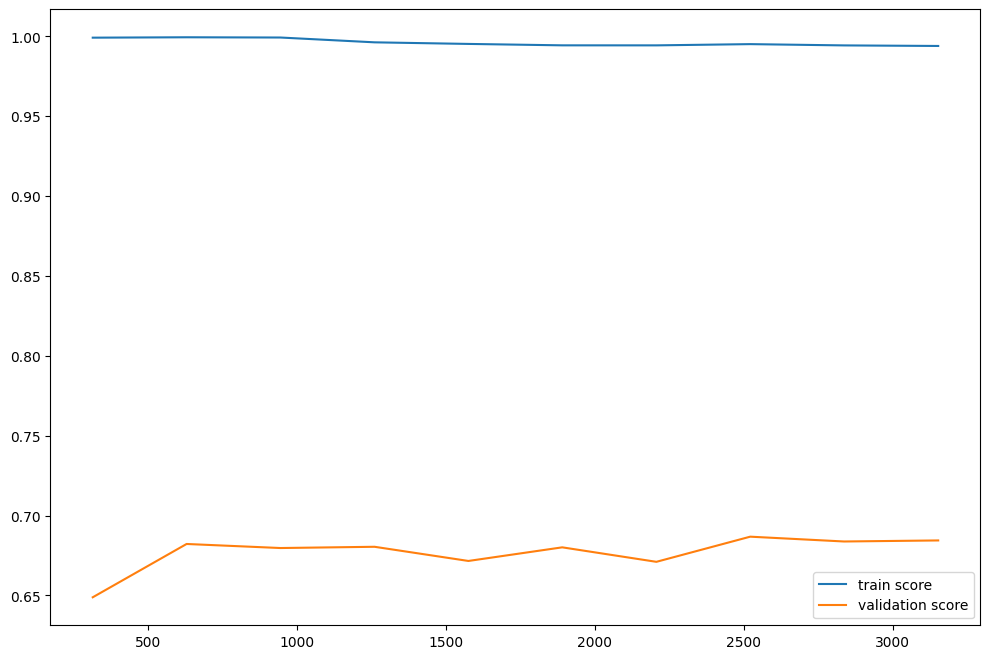

In [15]:
evaluation(model)

# OPTIMISATION

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

HELP: https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

In [17]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'smote', 'select', 'classifier', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'select__k', 'select__score_func', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classifier__warm_start'])

In [18]:
param_dict = {
    'smote__k_neighbors': [1],
    
    'select__k': [17, 18],
    
    'classifier__n_estimators': [100, 110, 120, 130, 140, 150, 160, 170],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [35, 30, 40],
    'classifier__min_samples_split': [6, 7, 8, 9, 10],
    'classifier__min_samples_leaf': [7],
    'classifier__max_features': [None],
}

In [19]:
grid = GridSearchCV(estimator = model, param_grid = param_dict, scoring='f1_macro', cv=4,  n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print(f"F1 score: {f1_score(y_test, y_pred, average='macro')}")

{'classifier__criterion': 'gini', 'classifier__max_depth': 35, 'classifier__max_features': None, 'classifier__min_samples_leaf': 7, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 100, 'select__k': 17, 'smote__k_neighbors': 1}
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       261
           1       0.78      0.79      0.79       195
           2       0.77      0.79      0.78       596

    accuracy                           0.74      1052
   macro avg       0.73      0.72      0.73      1052
weighted avg       0.74      0.74      0.74      1052

F1 score: 0.7267555182082326


In [20]:
rf1 = grid.best_estimator_
import joblib
joblib.dump(rf1, 'Football_Manager_rf1.joblib')

['Football_Manager_rf1.joblib']

In [21]:
# Load the model from the pickle file
import joblib
model = joblib.load('Football_Manager_rf1.joblib')

In [22]:
y_pred = model.predict(X_test)
y_pred

array([0, 2, 0, ..., 1, 0, 1], dtype=int64)

In [23]:
rf1_verif = y_test-y_pred

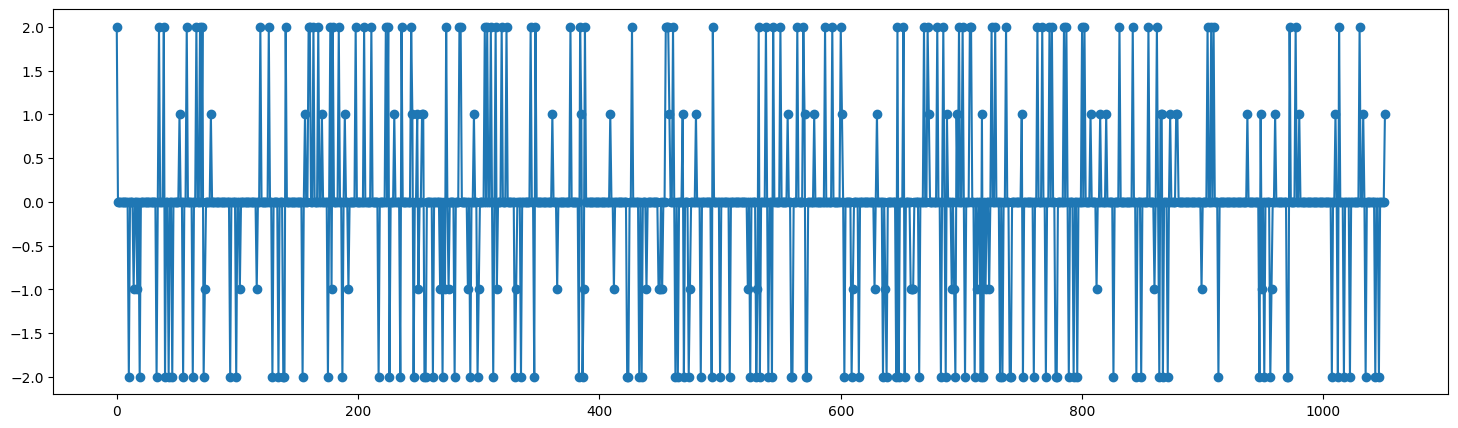

In [24]:
verif = y_test-y_pred
plt.figure(figsize=(18,5))
plt.plot(np.arange(len(verif)), verif, marker='o', linestyle='-')

# Modelisation XGBClassifier

#### My goal is to see if it's a good option to use a Stacking with my RF and XGB models


In [25]:
from xgboost import XGBClassifier
model_2 = XGBClassifier(random_state=42)

[[124   1 136]
 [  3 142  50]
 [ 53  16 527]]
              precision    recall  f1-score   support

           0       0.69      0.48      0.56       261
           1       0.89      0.73      0.80       195
           2       0.74      0.88      0.81       596

    accuracy                           0.75      1052
   macro avg       0.77      0.70      0.72      1052
weighted avg       0.76      0.75      0.74      1052

F1 score: 0.7232709896148153


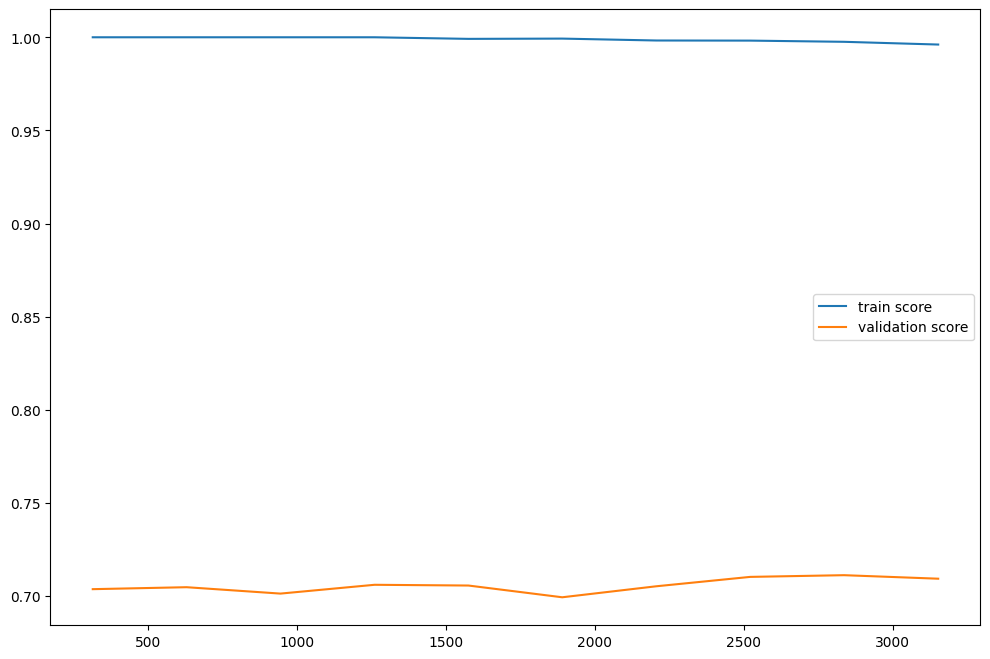

In [26]:
evaluation(model_2)

In [27]:
y_pred2 = model_2.predict(X_test)
y_pred2

array([1, 2, 0, ..., 1, 2, 2], dtype=int64)

Text(0, 0.5, 'Valeur')

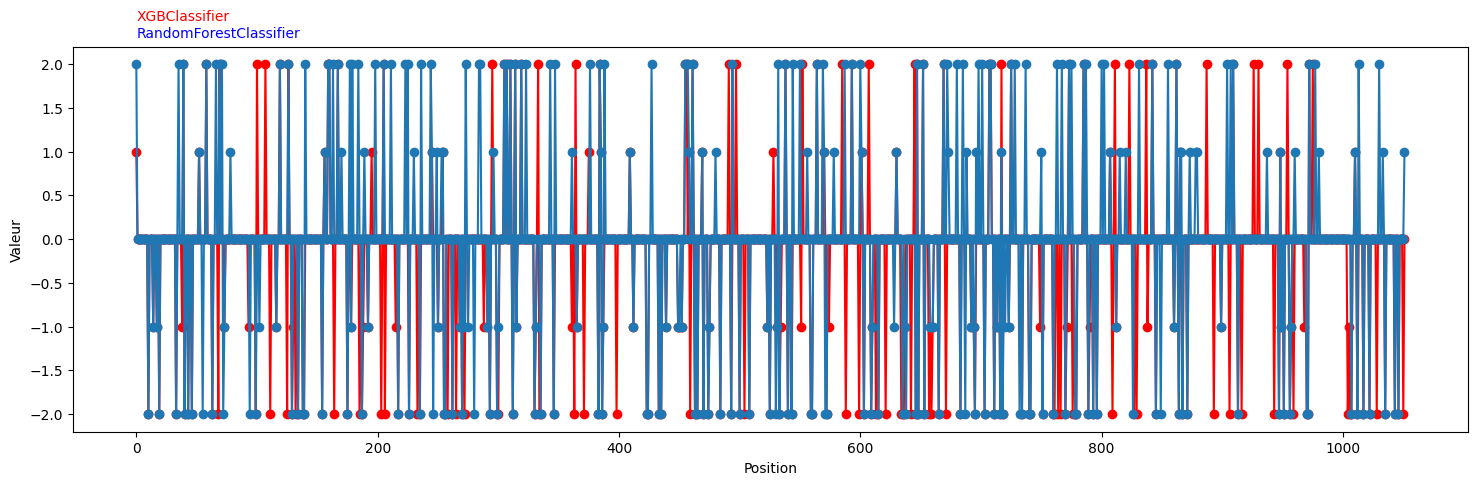

In [28]:
verif2 = y_test-y_pred2
plt.figure(figsize=(18,5))
plt.plot(np.arange(len(verif2)), verif2, marker='o', linestyle='-', color='r')
plt.plot(np.arange(len(rf1_verif)), rf1_verif, marker='o', linestyle='-')
plt.text(0.5, 2.5, 'XGBClassifier', color='r')
plt.text(0.5, 2.3, 'RandomForestClassifier', color='b')
plt.xlabel('Position')
plt.ylabel('Valeur')


#### The pics represent the errors when the models make predictions. We can see that a lot are different. Therefore, it could be a good idea to tune XGB and use Stacking with RF

In [29]:
from scipy.stats import uniform
param_dist2 = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.2),
    'reg_alpha': uniform(0, 0.2),
    'reg_lambda': uniform(0, 0.2),
}

In [30]:
grid2 = RandomizedSearchCV(estimator = model_2, param_distributions = param_dist2, scoring='f1_macro', n_iter = 100, cv=4,  n_jobs=-1)

grid2.fit(X_train, y_train)

print(grid2.best_params_)

y_pred2 = grid2.predict(X_test)

print(classification_report(y_test, y_pred2))
print(f"F1 score: {f1_score(y_test, y_pred2, average='macro')}")

{'colsample_bytree': 0.9054340217918646, 'gamma': 0.040281944327027946, 'learning_rate': 0.06261728396634605, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 164, 'reg_alpha': 0.15908581005533237, 'reg_lambda': 0.0656409325652274, 'subsample': 0.6061351597600511}
              precision    recall  f1-score   support

           0       0.72      0.44      0.54       261
           1       0.91      0.75      0.82       195
           2       0.74      0.91      0.82       596

    accuracy                           0.76      1052
   macro avg       0.79      0.70      0.73      1052
weighted avg       0.77      0.76      0.75      1052

F1 score: 0.7279824055452471


In [31]:
XGB = XGBClassifier(colsample_bytree = 0.7508536852776175, gamma = 0.12282262781379572, learning_rate = 0.07426358603297421, max_depth = 8, min_child_weight = 8, n_estimators = 137, reg_alpha = 0.16290107878514212, reg_lambda = 0.03731693163079757, subsample = 0.6057557992258489)

In [32]:
XGB

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7508536852776175, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.12282262781379572,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07426358603297421,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=137, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
model = RandomForestClassifier(criterion = 'gini', max_depth = 35, max_features = None, min_samples_leaf = 7, min_samples_split = 6, n_estimators = 130, random_state=42)
rf = imbpipeline(steps = [['select', SelectKBest(f_classif, k = 17)],
                                ['classifier', model]])

In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [35]:
estimators = [
     ('rf', rf),
     ('xgb', XGB)]

model_3 = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['classifier', StackingClassifier(estimators, RandomForestClassifier())]])

In [36]:
model_3.fit(X_train, y_train)
y_pred3 = model_3.predict(X_test)

print(classification_report(y_test, y_pred3))
print(f"F1 score: {f1_score(y_test, y_pred3, average='macro')}")

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       261
           1       0.83      0.77      0.80       195
           2       0.76      0.80      0.78       596

    accuracy                           0.74      1052
   macro avg       0.73      0.71      0.72      1052
weighted avg       0.73      0.74      0.73      1052

F1 score: 0.7216412618645928
